In [1]:
from pdrtpy.modelset import ModelSet
import numpy as np
from astropy.table import Table
import pdrtpy.pdrutils as utils
from pdrtpy.plot.lineratioplot import LineRatioPlot
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.plot.modelplot import ModelPlot
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
from pdrtpy import version
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from labellines import labelLine, labelLines
from lmfit import Model, Parameters, Minimizer, minimize
import corner
%matplotlib inline

/home/mpound/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1161: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(), op)(other)


In [2]:
m = ModelSet(name="wk2006",z=1)

In [3]:
version()

'2.1.1'

In [4]:
m.table.show_in_notebook()

idx,numerator,denominator,ratio,filename,z,title
,,,,,,null
0,OI_145,OI_63,OI_145/OI_63,oioiweb,1.0,[O I] 145 $\mu$m / [O I] 63 $\mu$m
1,OI_145,CII_158,OI_145/CII_158,o145ciiweb,1.0,[O I] 145 $\mu$m / [C II] 158 $\mu$m
2,OI_63,CII_158,OI_63/CII_158,oicpweb,1.0,[O I] 63 $\mu$m / [C II] 158 $\mu$m
3,CII_158,CI_609,CII_158/CI_609,ciici609web,1.0,[C II] 158 $\mu$m / [C I] 609 $\mu$m
4,CI_370,CI_609,CI_370/CI_609,ciciweb,1.0,[C I] 370 $\mu$m / [C I] 609 $\mu$m
5,CII_158,CO_10,CII_158/CO_10,ciicoweb,1.0,[C II] 158 $\mu$m / CO(J=1-0)
6,CII_158,CO_32,CII_158/CO_32,ciico32web,1.0,[C II] 158 $\mu$m / CO(J=3-2)
7,CII_158,CO_65,CII_158/CO_65,CII158_CO65,1.0,[C II] 158 $\mu$m / CO(J=6-5)
8,CII_158,FIR,CII_158/FIR,CII158_FIR,1.0,[C II] 158 $\mu$m / I$_{FIR}$


In [5]:
mp = ModelPlot(m)
'H264Q11/H210S1' in m.table['ratio']

Habing


True

In [6]:
try:
    m.model_ratios(["CII_158"])
except Exception as e:
    print("caught exception properly:",e)

mz = m.get_model('CII_158/CI_609')
mz.data.max()

caught exception properly: m most contain at least two strings


7066.33

[[ 9.01887035  0.39307201]
 [44.43040085 19.76740074]]
[9.01887035]
[8.60261744]
[7066.33007812]


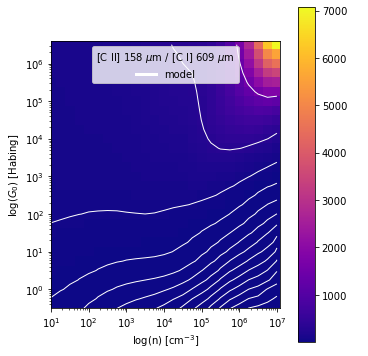

In [7]:
print(mz.get([3,1],[1,-.5],log=True))
print(mz.get(10,10**-.5,log=False))
mp.plot(mz.id)
mz.wcs
10**-.5
print(mz.get(1.1,-.45,log=True))
print(mz.get(1E7,10**6.5))
#print(mz[0,0])

In [8]:
mz.is_ratio()

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [9]:
# only residual not residual squared
def residual_single_pix(params,models,measurements):
    sum = 0.0
    parvals = params.valuesdict()
    
    mvalue = np.ones(len(models))
    dvalue = np.ones(len(measurements))
    evalue = np.ones(len(measurements))
    i=0
    for k in models:
        mvalue[i] = models[k].get(parvals['density'],parvals['radiation_field']) 
        dvalue[i] = measurements[k].value
        evalue[i] = measurements[k].error
        i = i+1
    return  (dvalue - mvalue)/evalue


In [10]:
try:
    m.get_models(['CII_158'],model_type='foo')
except ValueError as e:
    print("caught exception properly ",e)
x=m.get_models(["CI_609","FIR"],model_type="ratio")
y=m.get_models(["CI_609","FIR"],model_type="intensity")
z=m.get_models(["CI_609","FIR"],model_type="both")
q=m.get_models(['CII_158'],model_type='intensity')

caught exception properly  Unrecognized model_type: must be one of 'intensity', 'ratio', or 'both'


dict: {'CI_609': [1.5e-06] +/- 5e-07 erg / (cm2 s sr), 'CII_158/CI_609': [2] +/- 1 , 'OI_145': [3.e-06] +/- 1e-07 erg / (cm2 s sr), 'CII_158': [9.e-06] +/- 1e-06 erg / (cm2 s sr)}
<class 'pdrtpy.measurement.Measurement'>


1

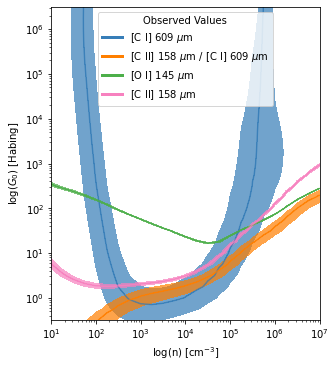

In [11]:
myunit = "erg s-1 cm-2 sr-1"
mx=Measurement(data=[1.5E-6],uncertainty = StdDevUncertainty(0.5E-6),identifier="CI_609",unit=myunit)
my=Measurement(data=[2],uncertainty = StdDevUncertainty(1),identifier="CII_158/CI_609",unit=u.dimensionless_unscaled)
mz=Measurement(data=[9E-6],uncertainty = StdDevUncertainty(1E-6),identifier="CII_158",unit=myunit)
mq=Measurement(data=[3E-6],uncertainty=StdDevUncertainty(1E-7),identifier="OI_145",unit=myunit)
a=[mx,my,mq,mz]
ids = [m.id for m in a]
d = dict(zip(ids,a))
print("dict:",d)
print(type(d["CI_609"]))
#d["CI_609"].levels
mp.overlay(a,shading=.71)
len(mx.data)
#q[1].id

In [12]:
myunit = "erg s-1 cm-2 sr-1" # my default unit for value and error
m1 = Measurement(data=6E-6,uncertainty = StdDevUncertainty(1E-6),identifier="OI_145",unit=myunit)
m2 = Measurement(data=2.2E-6,uncertainty = StdDevUncertainty(5E-7),identifier="CI_609",unit=myunit)
m3 = Measurement(data=260.0,uncertainty = StdDevUncertainty(40.0),identifier="CO_21",restfreq="230.538 GHz", unit="K km/s")
m4 = Measurement(data=2E-5,uncertainty = StdDevUncertainty(2E-6),identifier="CII_158",unit=myunit)
aa = [m1,m2,m3,m4]

In [13]:
np.size(m.get_model("CII_158"))

725

In [23]:
lrf = LineRatioFit(m,aa)
lrf.run()
print(lrf.density,lrf.radiation_field)
par = Parameters()
par.add('density',min=10,max=1E7,value=1E5)
par.add('radiation_field',min=1,max=1E6,value=10)
x=residual_single_pix(par,lrf._modelratios,lrf._observedratios)
print(x)
len(lrf._modelratios)
res=minimize(residual_single_pix,params=par,method='emcee',is_weighted=True,burn=300,steps=5000,args=(lrf._modelratios,lrf._observedratios))
res

/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/mpound/src/pdrtpy/pdrtpy/tool/lineratiofit.py:345: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


Converting K km/s to erg / (cm2 s sr) using Factor = +1.256E-08 g / (cm K s2)


  0%|          | 5/5000 [00:00<02:03, 40.56it/s]

316227.7660168379 +/- nan 1 / cm3 56.23413251903491 +/- nan Habing
[ 1.49335814 -2.82356136  2.44345703]


100%|██████████| 5000/5000 [01:57<00:00, 42.72it/s]


/home/mpound/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


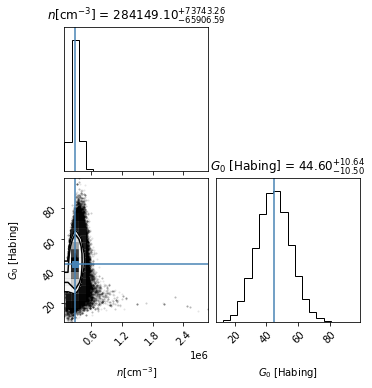

In [29]:
emcee_plot = corner.corner(res.flatchain, 
                           truths=list(res.params.valuesdict().values()),
                          show_titles=True,
                           labels=[r"$n [{\rm cm}^{-3}]$",r"$G_0$ [Habing]"])

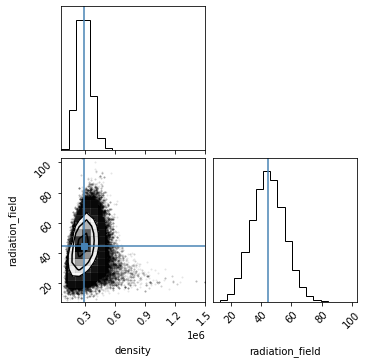

In [22]:
emcee_plot = corner.corner(res.flatchain, labels=res.var_names,
                           truths=list(res.params.valuesdict().values()))

In [ ]:
lrp = LineRatioPlot(lrf)
lrp.chisq()
np.min(lrf.chisq())

In [ ]:
mp.plot("CI_609",image=True)#measurements=[mx],image=False,legend=True,contours=True,label=True)

In [ ]:
mp.plot("CI_609/FIR",image=True,measurements=[mx],legend=True,label=True)

In [ ]:
#mp.plot("CI_609/FIR",image=True,measurements=[mx,my],legend=True,yaxis_unit=u.erg/(u.second*u.cm*u.cm),label=False)

In [ ]:
l = LineRatioFit(m,[mx])

In [ ]:
p = LineRatioPlot(l)

In [ ]:
l.modelset.supported_ratios.show_in_notebook()

In [ ]:
p.modelintensity("CI_609",measurements=[mx],legend=True,xaxis_unit="m-3",contours=True,label=True)

In [ ]:
identifiers1 = ["OI_63+CII_158/FIR","OI_63/CII_158"]
identifiers2 = ["CO_21","OI_63"]
identifiers3 = ["CO_65","CI_609/CO_43"]

In [ ]:
mp.phasespace(identifiers2,reciprocal=[False,False],dens_clip=[100,1E6]*u.Unit("cm-3"),rad_clip=[1,1E4]*utils._RFS_UNIT_)
#mp.savefig("OI_CO21.png",bbox_inches='tight',facecolor='white')